Sobre o conjunto de dados
Contexto
Motivado pelo web scrape de Gregory Smith do VGChartz Video Games Sales , este conjunto de dados simplesmente estende o número de variáveis ​​com outro web scrape do Metacritic . Infelizmente, faltam observações, pois o Metacritic cobre apenas um subconjunto das plataformas. Além disso, um jogo pode não ter todas as observações das variáveis ​​adicionais discutidas abaixo.

Contente
Ao lado dos campos: Nome, Plataforma, Ano de Lançamento, Gênero, Editora, Vendas NA , Vendas da UE , Vendas JP , Outras Vendas, Vendas Globais, temos:-

Critic_score - Pontuação agregada compilada pela equipe do Metacritic

Contagem de críticos - O número de críticos usados ​​para criar a pontuação da crítica

User_score - Pontuação dos assinantes do Metacritic

Contagem de usuários - Número de usuários que deram a pontuação do usuário

Desenvolvedor - Parte responsável pela criação do jogo

Classificação - As classificações ESRB

Reconhecimentos
Este repositório, https://github.com/wtamu-cisresearch/scraper , após alguns ajustes funcionou extremamente bem!

Inspiração
Seria interessante ver quaisquer técnicas de aprendizado de máquina ou visualizações de dados contínuas aplicadas nesse conjunto de dados.

# **PRÉ-PROCESSAMENTO**

In [4]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from tensorflow.keras import backend as k
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split


# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("games.csv")

In [7]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Vamoa retirar os dados onde o valor das vendas nos EUA for zero ou menor que US$ 1,00

In [8]:
df = df[df["NA_Sales"] > 1]
df = df[df["EU_Sales"] > 1]

**Vamos  excluir a "Developer", pois é uma coluna semelhante a "Publisher"**

In [9]:
df.drop(columns=["Developer"], axis=1, inplace=True)

**Verificando se há dados nulos**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 636
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             355 non-null    object 
 1   Platform         355 non-null    object 
 2   Year_of_Release  354 non-null    float64
 3   Genre            355 non-null    object 
 4   Publisher        354 non-null    object 
 5   NA_Sales         355 non-null    float64
 6   EU_Sales         355 non-null    float64
 7   JP_Sales         355 non-null    float64
 8   Other_Sales      355 non-null    float64
 9   Global_Sales     355 non-null    float64
 10  Critic_Score     260 non-null    float64
 11  Critic_Count     260 non-null    float64
 12  User_Score       267 non-null    object 
 13  User_Count       264 non-null    float64
 14  Rating           268 non-null    object 
dtypes: float64(9), object(6)
memory usage: 44.4+ KB


In [11]:
df.isna().sum()

Name                0
Platform            0
Year_of_Release     1
Genre               0
Publisher           1
NA_Sales            0
EU_Sales            0
JP_Sales            0
Other_Sales         0
Global_Sales        0
Critic_Score       95
Critic_Count       95
User_Score         88
User_Count         91
Rating             87
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 636
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             355 non-null    object 
 1   Platform         355 non-null    object 
 2   Year_of_Release  354 non-null    float64
 3   Genre            355 non-null    object 
 4   Publisher        354 non-null    object 
 5   NA_Sales         355 non-null    float64
 6   EU_Sales         355 non-null    float64
 7   JP_Sales         355 non-null    float64
 8   Other_Sales      355 non-null    float64
 9   Global_Sales     355 non-null    float64
 10  Critic_Score     260 non-null    float64
 11  Critic_Count     260 non-null    float64
 12  User_Score       267 non-null    object 
 13  User_Count       264 non-null    float64
 14  Rating           268 non-null    object 
dtypes: float64(9), object(6)
memory usage: 44.4+ KB


Verificando dados duplicados

In [13]:
df.duplicated().sum()

0

In [14]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,354.000000,355.000000,355.000000,355.000000,355.000000,355.000000,260.000000,260.000000,264.000000
mean,2006.042373,3.431944,2.292901,0.769183,0.638254,7.131915,83.857692,51.130769,1068.598485
std,6.129473,3.638778,2.220005,1.399739,0.677401,6.915759,9.589597,26.561763,1619.181563
min,1985.000000,1.010000,1.010000,0.000000,0.000000,2.430000,49.000000,8.000000,6.000000
25%,2002.000000,1.660000,1.225000,0.035000,0.290000,3.645000,79.000000,28.750000,105.750000
50%,2007.000000,2.450000,1.690000,0.130000,0.460000,5.020000,85.000000,48.500000,445.000000
75%,2011.000000,3.670000,2.365000,0.850000,0.755000,7.590000,91.000000,73.000000,1310.250000
max,2016.000000,41.360000,28.960000,10.220000,8.450000,82.530000,98.000000,113.000000,10179.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 636
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             355 non-null    object 
 1   Platform         355 non-null    object 
 2   Year_of_Release  354 non-null    float64
 3   Genre            355 non-null    object 
 4   Publisher        354 non-null    object 
 5   NA_Sales         355 non-null    float64
 6   EU_Sales         355 non-null    float64
 7   JP_Sales         355 non-null    float64
 8   Other_Sales      355 non-null    float64
 9   Global_Sales     355 non-null    float64
 10  Critic_Score     260 non-null    float64
 11  Critic_Count     260 non-null    float64
 12  User_Score       267 non-null    object 
 13  User_Count       264 non-null    float64
 14  Rating           268 non-null    object 
dtypes: float64(9), object(6)
memory usage: 44.4+ KB


In [16]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN


**Agora vamos tratar o NaN nas Features numérica:**

In [17]:
#"Year_of_Release" "Critic_Score", "Critic_Count", "User_Count"
ss = SimpleImputer(missing_values=np.nan, strategy="median")
ss.fit(df[["Year_of_Release", "Critic_Score", "Critic_Count", "User_Count"]])

m = ss.transform(df[["Year_of_Release", "Critic_Score", "Critic_Count", "User_Count"]])
df[["Year_of_Release", "Critic_Score", "Critic_Count", "User_Count"]] = m

**Agora vamos tratar o NaN nas Features categóricas**

In [18]:
#"User_Score", "Publisher", "Rating"
ss = SimpleImputer(strategy="constant", fill_value="unknown")
ss.fit(df[["User_Score", "Publisher", "Rating"]])

m = ss.transform(df[["User_Score", "Publisher", "Rating"]])
df[["User_Score", "Publisher", "Rating"]] = m

**Vamos transformar todas as Features categóricas em numéricas:**

In [19]:
oe =  OrdinalEncoder()
oe.fit(df[["Name", "Platform", "Genre","Publisher", "User_Score", "Rating"]])

df[["Name", "Platform", "Genre","Publisher", "User_Score", "Rating"]] = oe.transform(df[["Name", "Platform", "Genre","Publisher", "User_Score", "Rating"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [20]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Rating'],
      dtype='object')

In [21]:
ssc = StandardScaler()
ssc.fit(df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']])
h= ssc.transform(df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']])
df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']] = h

In [22]:
X = df.drop(columns=["Global_Sales"]).values
y = df["Global_Sales"].values

# **DATASET BASE**

In [23]:
#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [10],
          "kr__epochs":[5000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
26/26 [==============================] - 0s 1ms/step - loss: 1.1089 - mean_absolute_error: 1.1089
Epoch 2502/5000
26/26 [==============================] - 0s 1ms/step - loss: 1.0212 - mean_absolute_error: 1.0212
Epoch 2503/5000
26/26 [==============================] - 0s 1ms/step - loss: 0.8985 - mean_absolute_error: 0.8985
Epoch 2504/5000
26/26 [==============================] - 0s 1ms/step - loss: 1.2134 - mean_absolute_error: 1.2134
Epoch 2505/5000
26/26 [==============================] - 0s 2ms/step - loss: 1.1189 - mean_absolute_error: 1.1189
Epoch 2506/5000
26/26 [==============================] - 0s 2ms/step - loss: 1.0692 - mean_absolute_error: 1.0692
Epoch 2507/5000
26/26 [==============================] - 0s 2ms/step - loss: 1.1726 - mean_absolute_error: 1.1726
Epoch 2508/5000
26/26 [==============================] - 0s 1ms/step - loss: 1.2757 - mean_absolute_error: 1.2757
Epoch 2509/5000
26/26 [======================

A saída de streaming foi truncada nas últimas 5000 linhas.
26/26 [==============================] - 0s 2ms/step - loss: 0.9795 - mean_absolute_error: 0.9795
Epoch 2502/5000
26/26 [==============================] - 0s 2ms/step - loss: 0.7674 - mean_absolute_error: 0.7674
Epoch 2503/5000
26/26 [==============================] - 0s 2ms/step - loss: 0.9331 - mean_absolute_error: 0.9331
Epoch 2504/5000
26/26 [==============================] - 0s 2ms/step - loss: 0.7807 - mean_absolute_error: 0.7807
Epoch 2505/5000
26/26 [==============================] - 0s 2ms/step - loss: 0.9457 - mean_absolute_error: 0.9457
Epoch 2506/5000
26/26 [==============================] - 0s 3ms/step - loss: 0.8520 - mean_absolute_error: 0.8520
Epoch 2507/5000
26/26 [==============================] - 0s 2ms/step - loss: 0.8849 - mean_absolute_error: 0.8849
Epoch 2508/5000
26/26 [==============================] - 0s 3ms/step - loss: 0.9692 - mean_absolute_error: 0.9692
Epoch 2509/5000
26/26 [======================

A saída de streaming foi truncada nas últimas 5000 linhas.
29/29 [==============================] - 0s 1ms/step - loss: 1.3238 - mean_absolute_error: 1.3238
Epoch 2502/5000
29/29 [==============================] - 0s 1ms/step - loss: 1.2044 - mean_absolute_error: 1.2044
Epoch 2503/5000
29/29 [==============================] - 0s 1ms/step - loss: 0.9891 - mean_absolute_error: 0.9891
Epoch 2504/5000
29/29 [==============================] - 0s 2ms/step - loss: 1.3051 - mean_absolute_error: 1.3051
Epoch 2505/5000
29/29 [==============================] - 0s 2ms/step - loss: 1.1268 - mean_absolute_error: 1.1268
Epoch 2506/5000
29/29 [==============================] - 0s 2ms/step - loss: 1.0448 - mean_absolute_error: 1.0448
Epoch 2507/5000
29/29 [==============================] - 0s 1ms/step - loss: 1.0168 - mean_absolute_error: 1.0168
Epoch 2508/5000
29/29 [==============================] - 0s 2ms/step - loss: 1.0260 - mean_absolute_error: 1.0260
Epoch 2509/5000
29/29 [======================

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('kr',
                                        KerasRegressor(model=<function criarRede at 0x7fce3b377ef0>))]),
             param_grid={'kr__batch_size': [10], 'kr__epochs': [5000],
                         'kr__optimizer': ['adam']},
             scoring='neg_mean_absolute_error', verbose=10)

In [24]:
y_pred = grid_kr.predict(X_test)

8/8 [==============================] - 0s 1ms/step


In [25]:
tabela= pd.DataFrame()

In [26]:
tabela["Valor real"] = y_test
tabela["Valor preditivo"] = y_pred
tabela = tabela.sort_index()
tabela= tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo
0,0,4.16,3.922876
1,1,12.12,9.014181
2,2,3.74,3.655053
3,3,4.92,4.386394
4,4,10.30,7.814918
...,...,...,...
66,66,2.78,3.509140
67,67,4.62,4.228462
68,68,3.90,3.753216
69,69,7.39,5.998047


Salvando a tabela

In [27]:
tabela.to_csv("08_games_predição.csv")

In [29]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 84.07%


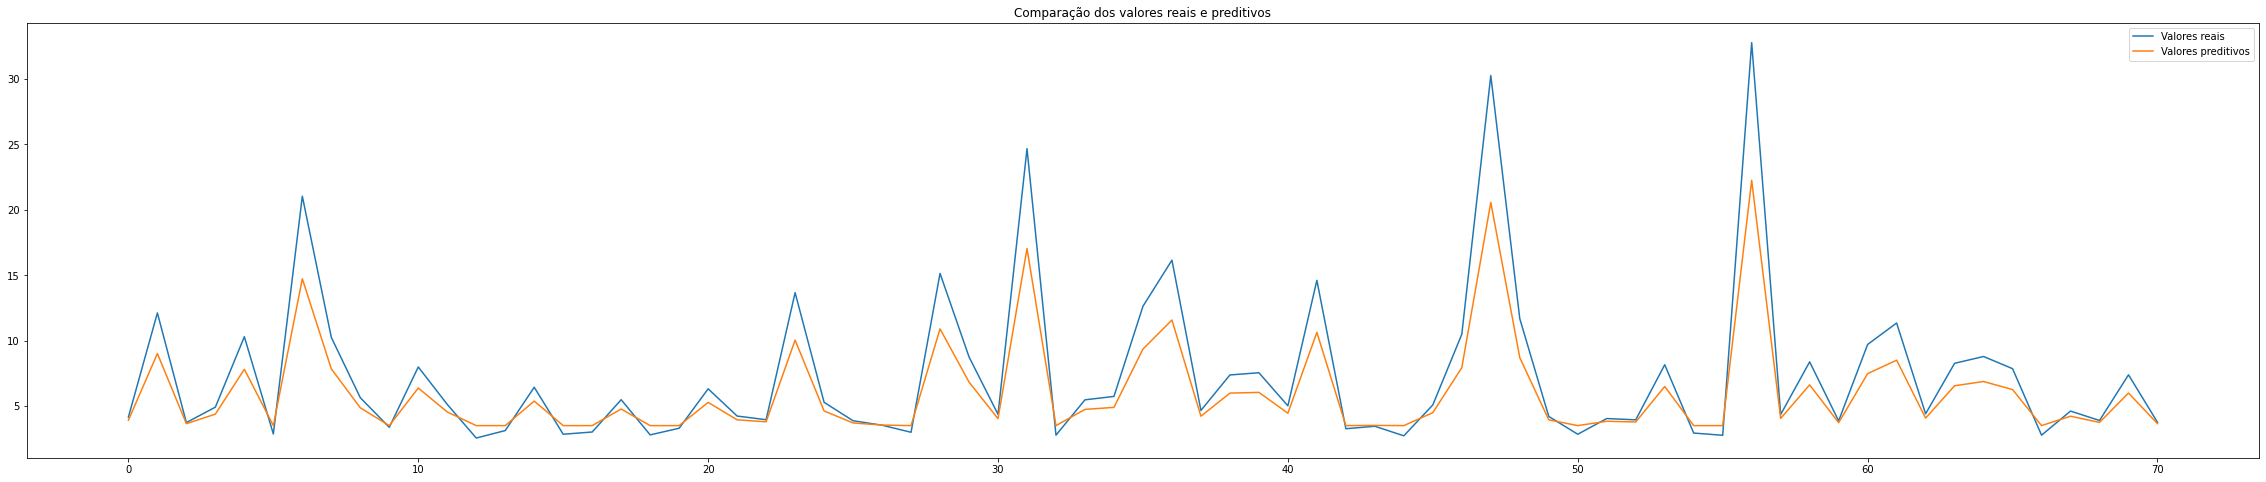

In [30]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();

In [31]:
import pickle

In [32]:
with open("grid_kr.pkl", "wb") as f:
    pickle.dump(grid_kr, f)

In [33]:
with open("grid_kr.pkl", "rb") as f:
    
    grid_kr = pickle.load(f)